In [1]:
SHUFFLE = False
BATCH_SIZE = 20
TEST_TRAIN = 0.25
file = 'Merged456-197-289_ICA(-eyes)+AUDpreproc.mat, DS2=64Hz, FIR=2-30Hz, centnorm=1, step=2, win=2, TD, 1-93.mat' #0.80(EEGnet.v2)

In [2]:
# get the Dataset:
import scipy.io as sio
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import pickle

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
from keras import backend as K
K.set_session(sess)


from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.models import load_model
from EEGModels import EEGNet, ShallowConvNet, DeepConvNet


def load_data(file, SHUFFLE, BATCH_SIZE, TEST_TRAIN):
        
    

    path = '/home/amplifier/home/DATASETS/' + file
    mat_contents = sio.loadmat(path)
    X = mat_contents['X']
    Y = mat_contents['Z']

    if X.shape[1]<X.shape[2]:
        X = np.transpose(X,[0,2,1])

    if Y.shape[1] > Y.shape[0]:
        Y = Y.T

    print('Original data shape:', X.shape)
    print('Original labels shape:', Y.shape)

    # verify that the model REALLY finds a mapping between the input and the labels. If we get
    # our accuracy by chance, then we should get the same accuracy on a permuted dataset:
    # Y = np.random.permutation(Y)


    # winsize = mat_contents['winsize']
    # stepsize = mat_contents['stepsize']
    # trial_len = mat_contents['trial_len']
    # low_cutoff = mat_contents['low_cutoff']
    # high_cutoff = mat_contents['high_cutoff']
    # source = mat_contents['filein']

    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=TEST_TRAIN, shuffle=SHUFFLE)
    print('Original data type:', x_train.dtype)

    # convert to float64 for numerical stability:
    x_train = x_train.astype('float64')
    y_train = y_train.astype('float64')
    x_test = x_test.astype('float64')
    y_test = y_test.astype('float64')

    # one hot encode the labels:
    onehot_encoder = preprocessing.OneHotEncoder(sparse=False)
    y_train = onehot_encoder.fit_transform(y_train)
    y_test = onehot_encoder.fit_transform(y_test)

    # convert to float16 to save space:
    x_train = x_train.astype('float16')
    y_train = y_train.astype('float16')
    x_test = x_test.astype('float16')
    y_test = y_test.astype('float16')
    print('Normalized data type:', x_train.dtype)

    leng = X.shape[1] # if you work in the FD, this is the height of the sample time-frequency image, othewise EEG channels
    chan = X.shape[2] # if you work in the FD, this is the width of the sample time-frequency image, othewise time samples of EEG signal

    if len(X.shape)==3:
        streams = 1 # this is EEG channels if you work with frequency domain, in the TD streams = 1
    if len(X.shape)==4:
        streams = X.shape[3] # this is EEG channels if you work with frequency domain, in the TD streams = 1


    print('test input shape', x_test.shape, "Nomralized MEAN:", np.mean(x_test), "min", np.min(x_test),"max", np.max(x_test))
    print('train input shape', x_train.shape, "Nomralized MEAN:", np.mean(x_train), "min", np.min(x_train),"max", np.max(x_train))

    print('test labels shape', y_test.shape, "Nomralized MEAN:", np.mean(y_test), "min", np.min(y_test),"max", np.max(y_test))
    print('train labels shape', y_train.shape, "Nomralized MEAN:", np.mean(y_train), "min", np.min(y_train),"max", np.max(y_train))

    # print('Window length', winsize)
    # print('Step size:', stepsize)
    # print('Trial length:', trial_len)
    
    return x_train, x_test, y_train, y_test

def rightsize(x_train, x_test, y_train, y_test):
    x_train = x_train.reshape(x_train.shape[0],1,x_train.shape[1],x_train.shape[2])
    x_train = x_train.transpose(0,1,3,2)
    x_test = x_test.reshape(x_test.shape[0],1,x_test.shape[1],x_test.shape[2])
    x_test = x_test.transpose(0,1,3,2)
#     print(x_train.shape,'\n',
#           x_test.shape,'\n',
#           y_train.shape,'\n',
#           y_test.shape)
    return x_train, x_test, y_train, y_test

Using TensorFlow backend.


In [3]:
test_labels = []
print('loading model 1 and weights...')
x_train, x_test, y_train, y_test = load_data(file, SHUFFLE, BATCH_SIZE, TEST_TRAIN)
x_train, x_test, y_train, y_test = rightsize(x_train, x_test, y_train, y_test)
test_labels.append(y_test) # keep the labels in the first dataset (in fact the data samples should represent the same EEG sections)
print('data loaded')
model = load_model('/home/amplifier/home/NEW_DL/models/EEGnet_NEWEST.h5')
model.load_weights('/home/amplifier/home/NEW_DL/weights/EEGnet_NEWEST_wts.h5')
print('model and weights loaded')

m1_decoded_train = model.predict(x_train)
m1_decoded_test = model.predict(x_test)
print('m1_decoded_train.shape', m1_decoded_train.shape)
print('m1_decoded_test.shape', m1_decoded_test.shape)
print('\n===========================\n')

print('loading data...')
x_train, x_test, y_train, y_test = load_data(file, SHUFFLE, BATCH_SIZE, TEST_TRAIN)
test_labels.append(y_test)
print('data loaded\n')

print('loading model 2 and weights...')
model = load_model('/home/amplifier/home/NEW_DL/models/EEGnet_CNN_Dense_Binary_Classifier_TD_1D.h5')
model.load_weights('/home/amplifier/home/NEW_DL/weights/EEGnet_CNN_Dense_Binary_Classifier_TD_1D_wts.h5')
print('model and weights loaded')
# let's predict a TRAINING sammple:
m2_decoded_train = model.predict(x_train)
m2_decoded_test = model.predict(x_test)
print('m2_decoded_train.shape', m2_decoded_train.shape)
print('m2_decoded_test.shape', m2_decoded_test.shape)
print('\n===========================\n')


print('loading data for model 3...')
with open('/home/amplifier/home/DATASETS/IMG_net_end_2end_data.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    x_train, x_test, y_train, y_test = pickle.load(f)
test_labels.append(y_test)
print('data loaded\n')
print('loading model 3 and weights...')
model = load_model('/home/amplifier/home/NEW_DL/models/IMG_net_2.h5')
model.load_weights('/home/amplifier/home/NEW_DL/weights/IMG_net_2_wts.h5')
print('model and weights loaded')
# let's predict a TRAINING sammple:
m3_decoded_train = model.predict(x_train)
m3_decoded_test = model.predict(x_test)
print('m3_decoded_train.shape', m3_decoded_train.shape)
print('m3_decoded_test.shape', m3_decoded_test.shape)
print('\n===========================\n')

loading model 1 and weights...
Original data shape: (450, 128, 60)
Original labels shape: (450, 1)
Original data type: float32
Normalized data type: float16
test input shape (113, 128, 60) Nomralized MEAN: -2.754e-05 min -4.816 max 5.66
train input shape (337, 128, 60) Nomralized MEAN: -1.25e-05 min -16.14 max 19.11
test labels shape (113, 2) Nomralized MEAN: 0.5 min 0.0 max 1.0
train labels shape (337, 2) Nomralized MEAN: 0.5 min 0.0 max 1.0
data loaded
model and weights loaded
m1_decoded_train.shape (337, 2)
m1_decoded_test.shape (113, 2)


loading data...
Original data shape: (450, 128, 60)
Original labels shape: (450, 1)
Original data type: float32
Normalized data type: float16
test input shape (113, 128, 60) Nomralized MEAN: -2.754e-05 min -4.816 max 5.66
train input shape (337, 128, 60) Nomralized MEAN: -1.25e-05 min -16.14 max 19.11
test labels shape (113, 2) Nomralized MEAN: 0.5 min 0.0 max 1.0
train labels shape (337, 2) Nomralized MEAN: 0.5 min 0.0 max 1.0
data loaded

loadin

In [4]:
# check if the labels are the same in all the datasets:
if not np.array_equal(test_labels[0],test_labels[1]) or not np.array_equal(test_labels[0],test_labels[2]) or not np.array_equal(test_labels[1],test_labels[2]):
    print('LABELS ARE NOT SAME!!!')
            
m1_decoded_test_hot = np.zeros_like(m1_decoded_test)
for i in range(len(m1_decoded_test)):
    m1_decoded_test_hot[i,0]=1 if m1_decoded_test[i,0]>=0.5 else 0
    m1_decoded_test_hot[i,1]=1 if m1_decoded_test[i,1]>0.5 else 0

m2_decoded_test_hot = np.zeros_like(m2_decoded_test)
for i in range(len(m2_decoded_test)):
    m2_decoded_test_hot[i,0]=1 if m2_decoded_test[i,0]>=0.5 else 0
    m2_decoded_test_hot[i,1]=1 if m2_decoded_test[i,1]>0.5 else 0

m3_decoded_test_hot = np.zeros_like(m3_decoded_test)
for i in range(len(m3_decoded_test)):
    m3_decoded_test_hot[i,0]=1 if m3_decoded_test[i,0]>=0.5 else 0
    m3_decoded_test_hot[i,1]=1 if m3_decoded_test[i,1]>0.5 else 0
    
# compute the voted prediction:
voting = np.stack([m1_decoded_test_hot, m2_decoded_test_hot, m3_decoded_test_hot], axis=2)
print(voting.shape)
voting = np.round(np.mean(voting, axis=2),0)
print(voting.shape)

(113, 2, 3)
(113, 2)


In [5]:
# calculate accuracy of the models and voting accuracy on the test set:
hits_m1 = (m1_decoded_test_hot==test_labels[0])[:,0]*1
hits_m2 = (m2_decoded_test_hot==test_labels[0])[:,0]*1
hits_m3 = (m3_decoded_test_hot==test_labels[0])[:,0]*1
hits_voting = (voting==test_labels[0])[:,0]*1


print('model 1 accuracy:', np.mean(hits_m1), '\n',
      'model 2 accuracy:', np.mean(hits_m2), '\n',
      'model 3 accuracy:', np.mean(hits_m3), '\n',
      'voting accuracy:', np.mean(hits_voting))

model 1 accuracy: 0.7964601769911505 
 model 2 accuracy: 0.7345132743362832 
 model 3 accuracy: 0.7256637168141593 
 voting accuracy: 0.8141592920353983


In [6]:
# look closer at the predictions
for i in range(len(test_labels[0])):
    print(m1_decoded_test_hot[i,:],
          m2_decoded_test_hot[i,:],
          m3_decoded_test_hot[i,:],
          '*' if np.array_equal(m1_decoded_test_hot[i,:], test_labels[0][i,:]) else ' ',
          '*' if np.array_equal(m2_decoded_test_hot[i,:], test_labels[0][i,:]) else ' ',
          '*' if np.array_equal(m3_decoded_test_hot[i,:], test_labels[0][i,:]) else ' ',
          '|',
          '*' if np.array_equal(voting[i,:], test_labels[0][i,:]) else ' ',
          '|',
          test_labels[0][i,:])

[1. 0.] [1. 0.] [1. 0.]       |   | [0. 1.]
[0. 1.] [1. 0.] [1. 0.] *     |   | [0. 1.]
[0. 1.] [1. 0.] [0. 1.] *   * | * | [0. 1.]
[0. 1.] [0. 1.] [1. 0.] * *   | * | [0. 1.]
[1. 0.] [1. 0.] [1. 0.]       |   | [0. 1.]
[1. 0.] [1. 0.] [1. 0.]       |   | [0. 1.]
[1. 0.] [1. 0.] [1. 0.]       |   | [0. 1.]
[0. 1.] [1. 0.] [0. 1.] *   * | * | [0. 1.]
[1. 0.] [1. 0.] [0. 1.] * *   | * | [1. 0.]
[1. 0.] [1. 0.] [1. 0.] * * * | * | [1. 0.]
[1. 0.] [1. 0.] [1. 0.] * * * | * | [1. 0.]
[1. 0.] [1. 0.] [1. 0.] * * * | * | [1. 0.]
[1. 0.] [1. 0.] [1. 0.] * * * | * | [1. 0.]
[1. 0.] [1. 0.] [1. 0.] * * * | * | [1. 0.]
[1. 0.] [0. 1.] [1. 0.] *   * | * | [1. 0.]
[1. 0.] [1. 0.] [1. 0.] * * * | * | [1. 0.]
[1. 0.] [1. 0.] [1. 0.] * * * | * | [1. 0.]
[1. 0.] [0. 1.] [1. 0.] *   * | * | [1. 0.]
[1. 0.] [1. 0.] [1. 0.] * * * | * | [1. 0.]
[1. 0.] [1. 0.] [1. 0.] * * * | * | [1. 0.]
[1. 0.] [1. 0.] [1. 0.] * * * | * | [1. 0.]
[1. 0.] [1. 0.] [1. 0.] * * * | * | [1. 0.]
[1. 0.] [1. 0.] [1. 0.] * * * | 

In [15]:
x_train[1,:,:,1].astype('float32')

array([[0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 6.9492188,
        7.015625 , 7.0390625, 6.9921875, 6.6484375, 0.       , 0.       ,
        0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 6.7695312, 7.1601562, 7.3554688,
        7.2773438, 7.25     , 7.0195312, 6.5742188, 6.0078125, 5.4804688,
        0.       , 0.       , 0.       ],
       [0.       , 0.       , 6.4804688, 7.1484375, 7.5742188, 7.5546875,
        7.3789062, 7.2304688, 6.921875 , 6.515625 , 6.2382812, 5.921875 ,
        5.484375 , 0.       , 0.       ],
       [0.       , 5.7382812, 6.3945312, 7.5117188

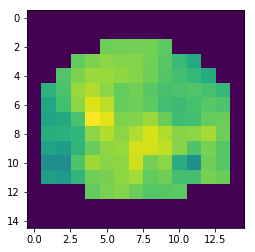

In [16]:


import matplotlib.pyplot as plt
% matplotlib inline
plt.imshow(x_train[1,:,:,1].astype('float32'))